## Real Stock Portfolio Optimization (VQE - Fractional Ansatz)

This example notebook uses a **Variational Quantum Eigensolver (VQE)** with a **fractional ansatz** to optimize a portfolio of real stocks (AAPL, MSFT, GOOGL, AMZN).

### Key Highlights:
- **Live data** from Yahoo Finance (`yfinance`)
- **Fractional weights** encoded via RY rotations:  
  $w_i = \sin^2(\theta_i / 2)$
- **Cost function** balances return, risk, and budget constraint:
  $\text{Cost} = -\mu^T w + q \cdot w^T \Sigma w + \text{penalty}$
- **Outputs**: Final weights, convergence plot, bar and pie charts.

This example shows how quantum circuits can solve real-world finance problems using hybrid quantum-classical methods.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath("../.."))
from Real_Stock_Data import get_stock_data

In [2]:
# Problem setup
q = 0.5  # Risk aversion parameter

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
mu, Sigma, prices = get_stock_data(tickers, start="2023-01-01", end="2024-01-01")
n_assets = len(mu)  # Dynamically detect from data

# print("mu (normalized):", mu)
# print("Sigma (normalized):", Sigma)

/workspaces/VQE_Portfolio_Optimization/Real_Stock_Data.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, group_by="ticker", progress=False)


In [3]:
dev = qml.device("default.qubit", wires=n_assets)


# Convert RY angles to weights (probability of measuring |1⟩)
def weights_from_thetas(thetas):
    return np.sin(thetas / 2) ** 2


@qml.qnode(dev)
def circuit(thetas):
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]


def cost_fn(thetas):
    weights = weights_from_thetas(thetas)
    expected_return = np.dot(mu, weights)
    risk = np.dot(weights, np.dot(Sigma, weights))
    penalty = 10 * (np.sum(weights) - 1.0) ** 2  # Encourage total weight = 1
    return -expected_return + q * risk + penalty

thetas = np.random.uniform(0, np.pi, n_assets, requires_grad=True)
opt = AdamOptimizer(0.1)
steps = 100
costs = []

for i in range(steps):
    thetas = opt.step(cost_fn, thetas)
    current_cost = cost_fn(thetas)
    costs.append(current_cost)
    if i % 10 == 0:
        print(f"Step {i} | Cost: {current_cost:.4f}")

Step 0 | Cost: 1055.6968
Step 10 | Cost: 211.8308
Step 20 | Cost: 2.8395
Step 30 | Cost: 2.0322
Step 40 | Cost: 2.4610
Step 50 | Cost: 0.1623
Step 60 | Cost: 0.2400
Step 70 | Cost: -0.1119
Step 80 | Cost: -0.1125
Step 90 | Cost: -0.1306


In [4]:
weights = weights_from_thetas(thetas)
weights = weights / np.sum(weights)  # Normalize

print("Optimized Portfolio Allocation:")
for i, w in enumerate(weights):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")

Optimized Portfolio Allocation:
Asset 1: 1.67%
Asset 2: 5.87%
Asset 3: 10.40%
Asset 4: 5.47%
Asset 5: 0.06%
Asset 6: 0.19%
Asset 7: 0.74%
Asset 8: 0.39%
Asset 9: 8.31%
Asset 10: 4.53%
Asset 11: 1.48%
Asset 12: 13.26%
Asset 13: 3.23%
Asset 14: 9.66%
Asset 15: 6.01%
Asset 16: 3.04%
Asset 17: 9.71%
Asset 18: 7.28%
Asset 19: 3.81%
Asset 20: 4.89%


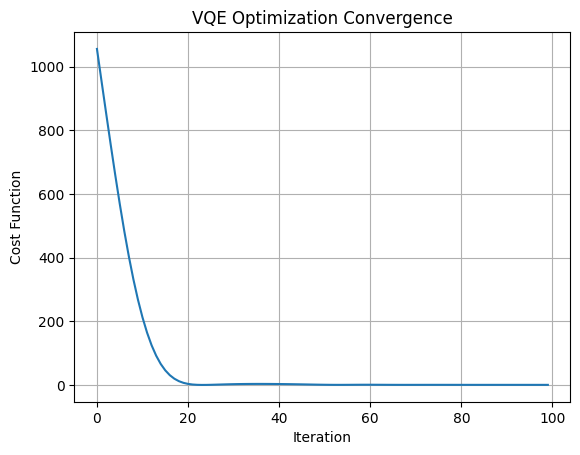

In [5]:
plt.plot(range(steps), costs)
plt.title("VQE Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost Function")
plt.grid(True)
plt.show()

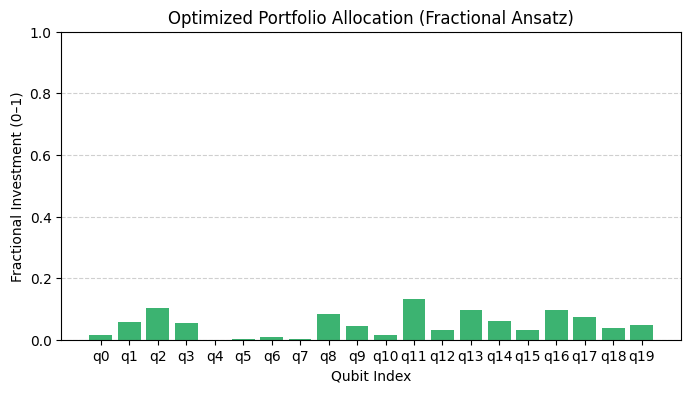

In [6]:
asset_labels = [f"q{i}" for i in range(n_assets)]

plt.figure(figsize=(8, 4))
plt.xticks(rotation=0, fontsize=10)
plt.bar(asset_labels, weights, color='mediumseagreen')
plt.title("Optimized Portfolio Allocation (Fractional Ansatz)")
plt.ylabel("Fractional Investment (0–1)")
plt.xlabel("Qubit Index")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

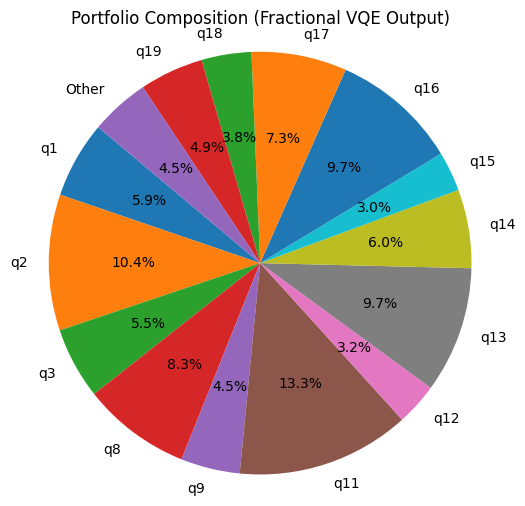

In [7]:
def simplify_weights(weights, labels, threshold=0.02):
    simplified_weights = []
    simplified_labels = []
    other_weight = 0.0

    for w, label in zip(weights, labels):
        if w >= threshold:
            simplified_weights.append(w)
            simplified_labels.append(label)
        else:
            other_weight += w

    if other_weight > 0:
        simplified_weights.append(other_weight)
        simplified_labels.append("Other")

    return simplified_weights, simplified_labels

simplified_weights, simplified_labels = simplify_weights(weights, asset_labels, threshold=0.02)

plt.figure(figsize=(6, 6))
plt.pie(simplified_weights, labels=simplified_labels, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Composition (Fractional VQE Output)")
plt.axis('equal')
plt.show()

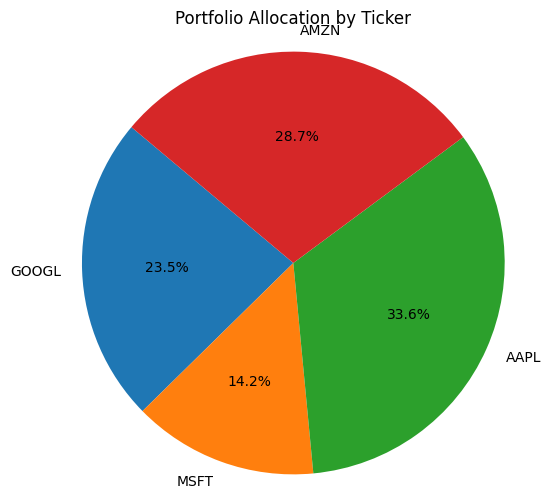

In [8]:
tickers = ['GOOGL', 'MSFT', 'AAPL', 'AMZN']
qubits_per_asset = 5
n_assets = len(tickers)

# Group weights per asset
aggregated_weights = []

for i in range(n_assets):
    start = i * qubits_per_asset
    end = (i + 1) * qubits_per_asset
    total_weight = np.sum(weights[start:end])
    aggregated_weights.append(total_weight)

# Normalize again (just in case)
aggregated_weights = np.array(aggregated_weights)
aggregated_weights /= np.sum(aggregated_weights)

plt.figure(figsize=(6, 6))
plt.pie(aggregated_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Ticker")
plt.axis('equal')
plt.show()
